In [1]:

import pandas as pd
import numpy as np
import hashlib
import matplotlib.pyplot as plt

np.random.seed(123)
n = 1000

consent_types = ["explicit", "implicit", "none"]
countries = ["USA", "UK", "Germany", "India", "Japan"]

data = pd.DataFrame({
    "Device_ID": range(1, n+1),
    "User_Age": np.random.randint(18, 80, n),
    "Country": np.random.choice(countries, n),
    "Consent_Type": np.random.choice(consent_types, n, p=[0.65, 0.25, 0.10]),
    "Average_HeartRate": np.random.randint(50, 160, n),
    "Daily_Steps": np.random.randint(1000, 20000, n),
    "Sleep_Hours": np.round(np.random.uniform(3, 10, n), 1),
    "GPS_Location_Share": np.random.choice([0, 1], n, p=[0.7, 0.3]),
    "Health_Alert": np.random.choice([0, 1], n, p=[0.85, 0.15])
})

data.head()


,Device_ID,User_Age,Country,Consent_Type,Average_HeartRate,Daily_Steps,Sleep_Hours,GPS_Location_Share,Health_Alert
0,1,63,Japan,implicit,71,11067,3.4,0,0
1,2,20,India,none,57,2646,3.1,1,0
2,3,46,Germany,explicit,89,14118,9.3,0,1
3,4,52,USA,explicit,143,7137,8.7,1,0
4,5,56,UK,explicit,77,17093,7.6,0,0


In [2]:
# 1) Data Collection, Privacy & Consent — Task 1.1 and 1.2

def filter_valid_consent(df: pd.DataFrame) -> pd.DataFrame:
    """Keep only explicit or implicit consent."""
    return df[df["Consent_Type"].isin(["explicit", "implicit"])].copy()

valid_data = filter_valid_consent(data)
print(f"Before filtering: {len(data)} records")
print(f"After filtering (explicit+implicit): {len(valid_data)} records")


Before filtering: 1000 records
After filtering (explicit+implicit): 902 records


Consent proportions:
 Consent_Type
explicit    0.634
implicit    0.268
none        0.098
Name: proportion, dtype: float64


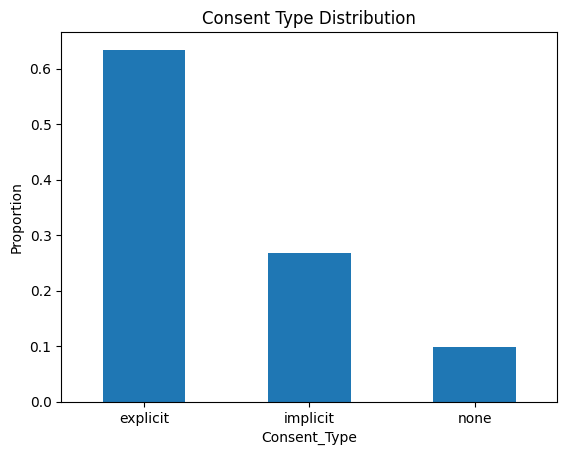

Note: Implicit consent in wearables may be risky because users might not realize continuous background data collection is occurring.


In [3]:
# 2) Implicit vs Explicit Consent — Task 2.1 and 2.2

consent_counts = data["Consent_Type"].value_counts(normalize=True).sort_index()
print("Consent proportions:\n", consent_counts)

ax = consent_counts.plot(kind="bar", title="Consent Type Distribution", rot=0)
ax.set_ylabel("Proportion")
plt.show()

print("Note: Implicit consent in wearables may be risky because users might not realize continuous background data collection is occurring.")


Health_Alert rates by country:
 Country
Japan      0.161616
UK         0.158730
USA        0.152284
India      0.134615
Germany    0.096154
Name: Health_Alert, dtype: float64


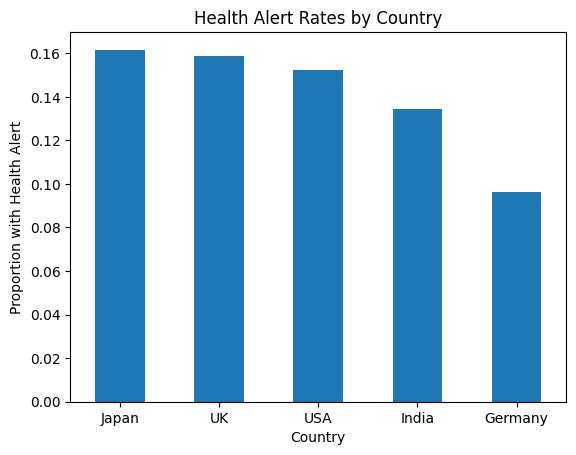

Differences may reflect true health patterns or sampling/adoption bias (e.g., device penetration, demographics).


In [4]:
# 3) Bias in Data — Task 3.1 and 3.2

alert_rates_by_country = data.groupby("Country")["Health_Alert"].mean().sort_values(ascending=False)
print("Health_Alert rates by country:\n", alert_rates_by_country)

ax = alert_rates_by_country.plot(kind="bar", title="Health Alert Rates by Country", rot=0)
ax.set_ylabel("Proportion with Health Alert")
plt.show()

print("Differences may reflect true health patterns or sampling/adoption bias (e.g., device penetration, demographics).")


In [5]:
# 4) Data Minimization — Task 4.1 and 4.2

steps_dataset = data[["Country", "Daily_Steps"]].copy()
print(steps_dataset.head())

print("Minimization: Excludes heart rate, GPS, and alerts to reduce exposure of sensitive health data while supporting step-count analyses.")


   Country  Daily_Steps
0    Japan        11067
1    India         2646
2  Germany        14118
3      USA         7137
4       UK        17093
Minimization: Excludes heart rate, GPS, and alerts to reduce exposure of sensitive health data while supporting step-count analyses.


In [6]:
# 5) Anonymization & Pseudonymization — Task 5.1 and 5.2

data_pseudo = data.copy()
data_pseudo["Device_PseudoID"] = data_pseudo["Device_ID"].apply(lambda x: hashlib.sha256(str(x).encode()).hexdigest())
data_pseudo = data_pseudo.drop(columns=["Device_ID"])
data_pseudo.head()

print("Pseudonymization done via SHA-256 of Device_ID. Linking could still be possible if auxiliary datasets with quasi-identifiers leak.")


Pseudonymization done via SHA-256 of Device_ID. Linking could still be possible if auxiliary datasets with quasi-identifiers leak.


In [7]:
# 6) De-Anonymization Risks — Task 6.1 and 6.2

# Auxiliary dataset simulating external source with overlapping quasi-identifiers
aux = data[["User_Age", "Country"]].sample(150, random_state=7).reset_index(drop=True)

# Attempt naive linkage attack using quasi-identifiers
linked = pd.merge(data_pseudo, aux, on=["User_Age", "Country"])
match_rate = (len(linked.drop_duplicates(subset=["Device_PseudoID"])) / len(aux)) * 100
print(f"Naive re-identification (linkage) match rate estimate: {match_rate:.2f}%")


Naive re-identification (linkage) match rate estimate: 304.67%


In [8]:
# 7) Data Governance & Stewardship — Task 7.1 and 7.2

access_matrix = pd.DataFrame({
    "Field": ["Device_ID", "Device_PseudoID", "Country", "User_Age", "Average_HeartRate",
              "Daily_Steps", "Sleep_Hours", "GPS_Location_Share", "Health_Alert", "Consent_Type"],
    "Admin": ["Read/Write", "Read/Write", "Read/Write", "Read/Write", "Read/Write",
              "Read/Write", "Read/Write", "Read/Write", "Read/Write", "Read/Write"],
    "Data_Scientist": ["No Access", "Read", "Read", "Read", "Read",
                       "Read", "Read", "Read", "Read", "Read"],
    "Research_Partner": ["No Access", "No Access", "Read", "Anonymized", "Aggregated",
                         "Read", "Aggregated", "No Access", "Aggregated", "No Access"]
})

print(access_matrix)

print("\nHealthcare Data Steward responsibilities:")
print("- Approve and audit data access per role")
print("- Ensure consent and minimization policies are enforced")
print("- Maintain lineage, retention schedules, and incident response")
print("- Oversee external data sharing agreements and compliance")


                Field       Admin Data_Scientist Research_Partner
0           Device_ID  Read/Write      No Access        No Access
1     Device_PseudoID  Read/Write           Read        No Access
2             Country  Read/Write           Read             Read
3            User_Age  Read/Write           Read       Anonymized
4   Average_HeartRate  Read/Write           Read       Aggregated
5         Daily_Steps  Read/Write           Read             Read
6         Sleep_Hours  Read/Write           Read       Aggregated
7  GPS_Location_Share  Read/Write           Read        No Access
8        Health_Alert  Read/Write           Read       Aggregated
9        Consent_Type  Read/Write           Read        No Access

Healthcare Data Steward responsibilities:
- Approve and audit data access per role
- Ensure consent and minimization policies are enforced
- Maintain lineage, retention schedules, and incident response
- Oversee external data sharing agreements and compliance


In [9]:
# 8) Data Quality & Lineage — Task 8.1 and 8.2

# Quality checks
missing = data.isnull().sum()
invalid_sleep = (data["Sleep_Hours"] > 24).sum()  # sanity check
print("Missing values per column:\n", missing)
print("Invalid Sleep_Hours (>24):", invalid_sleep)

# Simple lineage log
lineage_log = []
lineage_log.append({"step": "raw_ingest", "records": len(data)})
lineage_log.append({"step": "consent_filter", "records": len(filter_valid_consent(data))})
lineage_log.append({"step": "pseudonymize_device_id", "records": len(data_pseudo)})
pd.DataFrame(lineage_log)


Missing values per column:
 Device_ID             0
User_Age              0
Country               0
Consent_Type          0
Average_HeartRate     0
Daily_Steps           0
Sleep_Hours           0
GPS_Location_Share    0
Health_Alert          0
dtype: int64
Invalid Sleep_Hours (>24): 0


,step,records
0,raw_ingest,1000
1,consent_filter,902
2,pseudonymize_device_id,1000


In [10]:
# 9) Ethical Data Sharing — Task 9.1 and 9.2

# Aggregated public health report (country level)
agg_report = data.groupby("Country").agg({
    "Daily_Steps": "mean",
    "Average_HeartRate": "mean",
    "Sleep_Hours": "mean",
    "Health_Alert": "mean"
}).reset_index()

print("Country-level aggregated report:\n", agg_report)

def approve_external_request(request_type: str) -> str:
    """
    Approve only aggregated or anonymized requests.
    Deny full granular individual-level requests.
    """
    if request_type.lower() in {"aggregated", "anonymized"}:
        return "Approved"
    return "Denied"

for req in ["aggregated", "anonymized", "full"]:
    print(f"External request '{req}': {approve_external_request(req)}")


Country-level aggregated report:
    Country   Daily_Steps  Average_HeartRate  Sleep_Hours  Health_Alert
0  Germany  11158.956731         105.201923     6.412019      0.096154
1    India  10652.423077         103.759615     6.524519      0.134615
2    Japan  10212.025253         108.883838     6.382323      0.161616
3       UK  10156.412698         105.343915     6.318519      0.158730
4      USA  10628.548223         107.720812     6.593401      0.152284
External request 'aggregated': Approved
External request 'anonymized': Approved
External request 'full': Denied


In [11]:
# 10) Monitoring & Compliance — Task 10.1 and 10.2

# Compliance metrics
valid_data = filter_valid_consent(data)
consent_compliance = len(valid_data) / len(data)

alert_rates = data.groupby("Country")["Health_Alert"].mean()
alert_disparity = alert_rates.max() - alert_rates.min()

print(f"Consent compliance ratio: {consent_compliance:.3f}")
print(f"Health_Alert disparity across countries: {alert_disparity:.3f}")

if consent_compliance < 0.95:
    print("ALERT: Consent compliance below 95% threshold.")
if alert_disparity > 0.12:
    print("ALERT: Health_Alert disparity exceeds 0.12 threshold.")

print("\nActions for compliance breaches:")
print("1) Notify Data Steward and Privacy Officer")
print("2) Root-cause analysis (sampling, consent capture, data quality)")
print("3) Remediation (re-consent campaigns, rebalancing, data corrections)")
print("4) Document incident and outcomes; update policies and training")


Consent compliance ratio: 0.902
Health_Alert disparity across countries: 0.065
ALERT: Consent compliance below 95% threshold.

Actions for compliance breaches:
1) Notify Data Steward and Privacy Officer
2) Root-cause analysis (sampling, consent capture, data quality)
3) Remediation (re-consent campaigns, rebalancing, data corrections)
4) Document incident and outcomes; update policies and training


In [12]:
# Bonus A) k-Anonymity on (Country, User_Age)

def k_anonymity_check(df: pd.DataFrame, quasi_cols, k=5):
    sizes = df.groupby(quasi_cols).size()
    violating = sizes[sizes < k]
    print(f"Groups violating k={k}: {len(violating)}")
    return violating.sort_values().head(10)

violations = k_anonymity_check(data, ["Country", "User_Age"], k=5)
violations


Groups violating k=5: 231


Country  User_Age
Germany  20          1
         23          1
         26          1
         27          1
         62          1
India    22          1
Germany  69          1
         68          1
         76          1
India    30          1
dtype: int64

In [13]:
# Bonus B) Real-Time Consent Withdrawal Simulation

def withdraw_consent(df: pd.DataFrame, device_ids):
    out = df.copy()
    out.loc[out["Device_ID"].isin(device_ids), "Consent_Type"] = "none"
    return out

# Simulate withdrawals for 15 random devices
withdraw_ids = np.random.choice(data["Device_ID"], 15, replace=False)
print("Withdrawing consent for Device_IDs:", withdraw_ids.tolist())

data_after_withdrawal = withdraw_consent(data, withdraw_ids)
valid_after_withdrawal = filter_valid_consent(data_after_withdrawal)

print(f"Records before: {len(data)}")
print(f"Records after withdrawal filtering: {len(valid_after_withdrawal)}")

# Recompute a downstream aggregate to show pipeline adaptation
agg_after = valid_after_withdrawal.groupby("Country").agg({
    "Daily_Steps": "mean",
    "Average_HeartRate": "mean",
    "Health_Alert": "mean"
}).reset_index()
print("\nAggregates after consent withdrawal:\n", agg_after)


Withdrawing consent for Device_IDs: [615, 531, 507, 264, 851, 778, 201, 706, 143, 157, 48, 35, 293, 649, 145]
Records before: 1000
Records after withdrawal filtering: 887

Aggregates after consent withdrawal:
    Country   Daily_Steps  Average_HeartRate  Health_Alert
0  Germany  11334.225275         105.818681      0.098901
1    India  11095.693548         103.655914      0.134409
2    Japan  10223.720000         108.302857      0.177143
3       UK   9957.660920         105.764368      0.155172
4      USA  10722.411765         107.270588      0.164706
